<a href="https://colab.research.google.com/github/Shifath472533/All-Image-captioning-models-and-links-for-data-sets-in-Bangla/blob/master/ResNet_Bangla_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Mounting <b>google drive</b></h3>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Setting up <b>dependencies</b></h3>

In [18]:
!pip install --upgrade pip
!pip install pycocotools
!pip install git+https://github.com/salaniz/pycocoevalcap          #this is for pycocoevalcap library to calulate metrics

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1)
  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-i26oi9if
  Running command git clone -q https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-i26oi9if
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.1-py3-none-any.whl size=104310213 sha256=99bbf3ab3fa5509906b197ea01448126b550a195765aae1a3bdc90a0c106ad9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-v3a5ozsh/wheels/df/74/69/758b2491ca93bf681a1509671df34df9cf5ff605edf6e112ed
Successfully built pycocoevalcap


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing <b>Libraries</b></h3>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import notebook as tq
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import array
import pickle
import numpy as np
import os
import cv2

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing <b>Libraries</b> for metrics from <b>nltk</b></h3>

In [0]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.gleu_score import corpus_gleu
from nltk.translate.bleu_score import SmoothingFunction

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing Libraries for <b>pycocoevalcap</b></h3>

In [0]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading **image directory** and counting the <b>No. of images</b></h3>

In [0]:
cap_per_img = {}
defected_cap = {}

In [23]:
cnt_img = 0
#image directory
img_dir = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/images"

for filename in os.listdir(img_dir):
  cap_per_img[filename] = []
  defected_cap[filename] = []
  cnt_img+=1
    
print("Number of images : " , cnt_img)
print("Number of captions should be : " , cnt_img*2)

Number of images :  9154
Number of captions should be :  18308


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Checking If captions are defected and print if it is with Image names</h3>

In [24]:
token_dir = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/token.txt"

cnt_cap = 0

with open (token_dir, "r",encoding="utf-16") as fileHandler:
  for line in fileHandler:
    sentence = line.strip()
    sentences = sentence.split("\t")
    ans = sentences[0]
    ans1 = ans.split("#")
    # print(ans1[0] , " : ",ans1[1])
    if ans1[0]=='\ufeff01.png':
      ans1[0] = '01.png'
    #   continue
    if ans1[0] in cap_per_img:
      cap_per_img[ans1[0]].append(ans1[1])
      cnt_cap+=1
    else:
      defected_cap[ans1[0]].append(ans1[1])

# print(cnt_cap)

if(cnt_img*2 == cnt_cap):
  print("All captions are okay.")
elif(len(defected_cap) > 0):
  print("Defected captions : ")
  for img_nm in defected_cap:
    print("Image Name : ",img_nm,"  Number : ",defected_cap[img_nm])          


All captions are okay.


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the directories of **token.csv** , **train.txt** , **test.txt** and **validation.txt** files and converting them to pandas &nbsp;&nbsp;dataframe</h3>

In [0]:
image_tokens=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/token.txt",encoding = 'utf-16', sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/TrainImages.txt.txt",encoding = 'utf-16',names=["img_id"])
test_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/TestImages.txt.txt",encoding = 'utf-16',names=["img_id"])
val_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/ValidationImages.txt.txt",encoding = 'utf-16',names=["img_id"])

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing the <b>image_tokens</b></h3>

In [124]:
image_tokens.head(5) 

,img_id,img_caption
0,01.png#0,দুই জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর এক ...
1,01.png#1,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে এ...
2,02.png#0,জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছ...
3,02.png#1,২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চা...
4,03.png#0,অনেক মেয়ে মানুষ বসে আছে।


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing the <b>train image names</b></h3>

In [121]:
train_image_names.head(5)

,img_id
0,01.png
1,02.png
2,03.png
3,04.png
4,05.png


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing one of the <b>train images</b></h3>

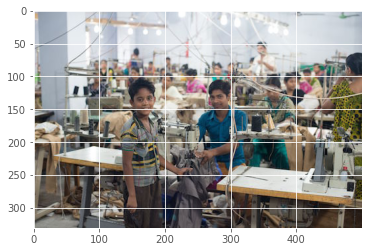

In [28]:
img=cv2.imread(img_dir+ "/" +train_image_names.img_id[3])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Removing the #0 , #1 from the <b>image ids</b></h3>

In [0]:
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing the <b>image_tokens</b> again</h3>

In [30]:
image_tokens.head(5)

,img_id,img_caption
0,01.png,দুই জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর এক ...
1,01.png,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে এ...
2,02.png,জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছ...
3,02.png,২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চা...
4,03.png,অনেক মেয়ে মানুষ বসে আছে।


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Creating **train dictionary** having key as the image id and value as a list of its captions</h3>

In [31]:
train_captions={}
for i in tq.tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Creating **test dictionary** having key as the image id and value as a list of its captions</h3>

In [32]:
test_captions={}
for i in tq.tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Creating **validation dictionary** having key as the image id and value as a list of its captions</h3>

In [33]:
validation_captions={}
for i in tq.tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing the **ResNet50** model and printing the <b>summary</b></h3>

In [0]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the path to save the <b>pickle file</b></h3>

In [0]:
pickle_path = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/"

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Extracting image encodings(features) from **ResNet50** and forming dict **train_features** and encoding as a <b>pkl</b> &nbsp;&nbsp;file</h3>

In [0]:
path=img_dir+"/"
train_features={}
c=0
for image_name in tq.tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

In [0]:
print("After Extracting Features length of train_features : ")
print(len(train_features))

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving the train_features as <b>pickle file</b></h3>

In [0]:
with open( pickle_path+"train_encoded_images.pkl", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the saved <b>pickle file</b> in train_features</h3>

In [0]:
train_features = {}
pickle_in = open(pickle_path + "train_encoded_images.pkl","rb")
train_features = pickle.load(pickle_in)

In [36]:
print("After Extracting from pkl file length of train_features : ")
print(len(train_features))

After Extracting from pkl file length of train_features : 
7154


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Extracting image encodings(features) from **ResNet50** and forming dict <b>test_features</b> and encoding as a <b>pkl</b> &nbsp;&nbsp;file</h3>

In [0]:
path=img_dir+"/"
test_features={}
c=0
for image_name in tq.tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving the test_features as <b>pickle file</b></h3>

In [0]:
with open( pickle_path+"test_encoded_images.pkl", "wb" ) as pickle_f1:
    pickle.dump(test_features, pickle_f1 )

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the saved <b>pickle file</b> in test_features</h3>

In [0]:
test_features = {}
pickle_in = open(pickle_path + "test_encoded_images.pkl","rb")
test_features = pickle.load(pickle_in)

In [38]:
print("After Extracting from pkl file length of test_features : ")
print(len(test_features))

After Extracting from pkl file length of test_features : 
1000


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Extracting image encodings(features) from **ResNet50** and forming dict <b>validation_features</b> and encoding as a <b>&nbsp;&nbsp;pkl</b> file</h3>

In [0]:
path=img_dir+"/"
validation_features={}
c=0
for image_name in tq.tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving the validation_features as <b>pickle file</b></h3>

In [0]:
with open( pickle_path+"validation_encoded_images.pkl", "wb" ) as pickle_f2:
    pickle.dump(validation_features, pickle_f2 )

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the saved <b>pickle file</b> in validation_features</h3>

In [0]:
validation_features = {}
pickle_in = open(pickle_path + "validation_encoded_images.pkl","rb")
validation_features = pickle.load(pickle_in)

In [40]:
print("After Extracting from pkl file length of validation_features : ")
print(len(validation_features))

After Extracting from pkl file length of validation_features : 
1000


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving all words <b>all_words</b> and unique words in <b>unique_words</b></h3>

In [41]:
all_captions=[]
for img_id in tq.tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print("Length of all words -- ")
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print("Length of unique words -- ")
print(len(unique_words))


Length of all words -- 
674021
Length of unique words -- 
5456


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining **max_length** and **vocabulary size**</h3>

In [0]:
vocab_size=len(unique_words)+1
max_length=40

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Forming dictionaries containing mapping of **words to indices** and <b>indices to words</b></h3>

In [0]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Forming dictionary having <b>encoded captions</b></h3>

In [44]:
train_encoded_captions={}
for img_id in tq.tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(2):
    # print(img_id)
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

print(train_encoded_captions)


{'01.png': [[4010, 2675, 4103, 4781, 3885, 2814, 2675, 1841, 1110, 3336, 2814, 2675, 818, 3885], [3417, 3803, 678, 866, 3315, 460, 1841, 2858, 3417, 1856, 4621, 3913, 3590, 507, 3336, 2707, 3417, 4103, 1635, 4757, 4621, 818, 2693]], '02.png': [[56, 743, 4390, 2911, 4781, 5240, 3417, 5377, 4781, 3885, 1484, 1635, 1159, 4246, 3885], [2678, 2675, 4781, 5323, 4390, 2300, 3417, 1036, 1841, 4482, 1, 4212, 1913, 3324, 2146, 1428, 5456, 5240, 983, 2707, 2911, 2488, 1118, 2215, 518, 58, 5323, 2051, 3255, 4091, 5240, 2840, 2217]], '03.png': [[4985, 4103, 4781, 818, 3885], [3417, 1167, 678, 3315, 460, 3417, 1167, 2021, 379, 4133, 3943, 1110, 3086, 1635, 1, 794, 4133, 687, 1577, 2164, 3315, 5012, 460, 3943, 3885]], '04.png': [[4985, 4781, 39, 818, 1204, 4678], [2678, 741, 1, 2707, 2911, 4390, 3122, 4091, 5456, 1841, 1197, 1110, 5240, 983, 818, 4138, 743, 1204, 2277, 1167, 1, 3122, 5456, 3086, 1484, 1635, 5012, 460, 1841, 5240, 818, 1204, 4678]], '05.png': [[494, 2675, 4781, 4968, 1841, 3885], [18

In [45]:
for img_id in tq.tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the <b>data_generator</b> method to fit the model</h3>

In [0]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tq.tqdm(train_encoded_captions):
    n+=1
    for i in range(2):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing **Libraries**</h3>

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining <b>Model</b> for generating captions</h3>

In [0]:
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
#lstm_1=LSTM(256)(dropout_2)

#changes done to integrate 1D- Convolutional layer
conv_1D = Conv1D(filters=256, kernel_size=3, activation='relu')(dropout_2)
pool_1 = GlobalMaxPooling1D()(conv_1D)

add_1=add([dense_1,pool_1])
#add_2=add([add_1,pool_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Compiling the <b>model</b></h3>

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Fitting the model with <b>epoch 1</b></h3>

In [0]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in tq.tqdm(range(epochs)):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Fitting the model with <b>epoch 10</b></h3>

In [0]:
epochs=5
no_of_photos=25
steps=len(train_encoded_captions)//no_of_photos
for i in tq.tqdm(range(epochs)):
  print("epoch number : ",i+1)
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=2)

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;saving the model as <b>resnet50_with_cnn_bangla_dataset_chittron.h5</b></h3>

In [0]:
# model.save('/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/resnet50_with_cnn_bangla_dataset_chittron.h5')

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the saved model from <b>resnet50_with_cnn_bangla_dataset_chittron.h5</b></h3>

In [48]:
model = load_model('/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/resnet50_with_cnn_bangla_dataset_chittron.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining method for <b>Greedy Search</b></h3>

In [0]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining method for <b>Beam Search</b></h3>

In [0]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining method for calculating scores by <b>pycocoevalcap</b></h3>

In [0]:
def calc_scores_pycoco(ref, hypo, verbose):
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE")
    ]
    final_scores = {}
    if(verbose == 1):
        scorerss = tq.tqdm(scorers)
    else:
        scorerss = scorers
    for scorer, method in scorerss:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining method for calculating scores by <b>nltk</b></h3>

In [0]:
def calc_scores_nltk(ref,hypo):
    smf = SmoothingFunction()
    smoothing_functions = [smf.method1, smf.method2, smf.method3, smf.method4, smf.method5, smf.method7]
    weights = [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (.25, .25, .25, .25)]
    score_nltk = {'sentence_bleu_average':{},'sentence_gleu_average':{},'corpus_bleu':{},'corpus_gleu':{}}
    length = len(ref)
    for smoothing_function in tq.tqdm(smoothing_functions):
        score_nltk['sentence_bleu_average']["smoothing_function_method_0"+str(smoothing_functions.index(smoothing_function)+1)]={}
        score_nltk['corpus_bleu']["smoothing_function_method_0"+str(smoothing_functions.index(smoothing_function)+1)]={}
        for weight in weights:
            temp = 0.
            for i in range(length):
                temp += sentence_bleu(ref[i], hypo[i],smoothing_function=smoothing_function, weights=weight)
            score_nltk['sentence_bleu_average']["smoothing_function_method_0"+str(smoothing_functions.index(smoothing_function)+1)]["weight_0"+str(weights.index(weight)+1)] = round(temp/length,4)
            score_nltk['corpus_bleu']["smoothing_function_method_0"+str(smoothing_functions.index(smoothing_function)+1)]["weight_0"+str(weights.index(weight)+1)] = round(corpus_bleu(ref, hypo,smoothing_function=smoothing_function, weights=weight),4)

    temp = 0.
    for i in range(length):
        temp += sentence_gleu(ref[i], hypo[i])
    score_nltk['sentence_gleu_average'] = round(temp/length,4)
    score_nltk['corpus_gleu'] = round(corpus_bleu(ref, hypo),4)
    print(score_nltk)
    return score_nltk

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Declaring the <b>references</b> and <b>hypotheses</b> lists and dictionaries.</h3>

In [0]:
References={'nltk':[],'pycoco':{}}
Hypotheses={'nltk':{'greedy':[],'beam_3':[],'beam_5':[],'beam_7':[]},'pycoco':{'greedy':{},'beam_3':{},'beam_5':{},'beam_7':{}}}

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the <b>purify</b> method to remove Unk in predicted captions.</h3>

In [0]:
def purify(ref):
    if('Unk' in ref):
        idx_unk = ref.index('Unk')
        ref=ref[:idx_unk]
    return ref

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving the <b>references</b> and <b>hypotheses</b> captions for test images.</h3>

In [0]:
for img_id in tq.tqdm(test_features):
    photo=test_features[img_id]
    reference=[]
    for caps in test_captions[img_id]:
        list_caps=caps.split(" ")
        list_caps=list_caps[1:-1]
        reference.append(list_caps)

    #Outputs
    greedy_out = purify(greedy_search(photo))
    beam_3_out = purify(beam_search(photo,3))
    beam_5_out = purify(beam_search(photo,5))
    beam_7_out = purify(beam_search(photo,7))

    # saving captions for nltk libraries
    References['nltk'].append(reference)
    Hypotheses['nltk']['greedy'].append(greedy_out)
    Hypotheses['nltk']['beam_3'].append(beam_3_out)
    Hypotheses['nltk']['beam_5'].append(beam_5_out)
    Hypotheses['nltk']['beam_7'].append(beam_7_out)
    # saving captions for nltk libraries
    References['pycoco'][img_id] = [" ".join(reference[0]), " ".join(reference[1])]
    Hypotheses['pycoco']['greedy'][img_id] = " ".join(greedy_out)
    Hypotheses['pycoco']['beam_3'][img_id] = " ".join(beam_3_out)
    Hypotheses['pycoco']['beam_5'][img_id] = " ".join(beam_5_out)
    Hypotheses['pycoco']['beam_7'][img_id] = " ".join(beam_7_out)

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the path to save <b>references</b> and <b>hypotheses</b> dictionaries as pickle file.</h3>

In [0]:
ref_pickle_path = '/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/references.pkl'
hypo_pickle_path = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/hypothesis.pkl"

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving <b>references</b> dictionary as a pickle file.</h3>

In [0]:
with open(ref_pickle_path, "wb" ) as pickle_f:
    pickle.dump(References, pickle_f )

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the <b>references</b> dictionary from pickle file.</h3>

In [56]:
References = {}
pickle_in = open(ref_pickle_path, "rb")
References = pickle.load(pickle_in)
References

{'nltk': [[['শিশু', 'বসে'],
   ['ভিতরে', 'ঘর', 'বানিয়ে', 'বসে', 'আছে', 'একজন', 'বাচ্চা']],
  [['মানুষ'],
   ['উপরে', 'আঁকাবাঁকা', 'রাস্তা', 'যার', 'উপর', 'দিয়ে', '১', 'জন', 'হেটে']],
  [['নারী', 'ও', 'পুরুষ', 'বসে'], ['কয়েকজন', 'ছেলেমেয়ে', 'বসে', 'তাকিয়ে']],
  [['নৌকায়', 'একজন', 'মানুষ', 'বসে'],
   ['খালে', 'একটি', 'নৌকায়', '১', 'জন', 'লোক', 'বসে']],
  [['কয়েকজন', 'পুরুষ', 'দাড়িয়ে'],
   ['জন',
    'ছেলে',
    'একসাথে',
    'একটি',
    'দেয়ালে',
    'ধাক্কা',
    'দিয়ে',
    'দাড়িয়ে',
    'তাকিয়ে',
    'আছে']],
  [['বয়স্ক', 'পুরুষ'],
   ['বুড়ো',
    'পুরুষ',
    'কালো',
    'সান',
    'গ্লাস',
    'পরে',
    'তাকিয়ে',
    'আছেন',
    'যার',
    'চুল',
    'কালো',
    'দাড়িগোঁফ',
    'হলুদ']],
  [['নৌকার', 'উপর', 'দুইজন', 'মানুষ'],
   ['নৌকায়', '২', 'জন', 'মানুষ', 'এবং', 'পাশে']],
  [['নারী', 'কাজ'], ['জন', 'মহিলা', 'চাতালে', 'ধান', 'শুকানোর', 'কাজ']],
  [['নারী', 'তাকিয়ে'],
   ['হাত', 'রেখে', 'চুল', 'ছেড়ে', 'তাকিয়ে', 'আছেন', 'একজন']],
  [['মানুষ'],
   ['জন',
    'ইফতার',
    'বিক্রেতা',

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving the <b>hypotheses</b>dictionary as pickle file.</h3>

In [0]:
with open(hypo_pickle_path, "wb" ) as pickle_f:
    pickle.dump(Hypotheses, pickle_f )

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the <b>hypotheses</b> dictionary from pickle file.</h3>

In [57]:
Hypotheses = {}
pickle_in = open(hypo_pickle_path, "rb")
Hypotheses = pickle.load(pickle_in)
Hypotheses

{'nltk': {'beam_3': [['বেডে',
    'বেডে',
    'চরে',
    'লিখছে।',
    'সেতুসহ',
    'মুস্তাফিজের',
    'ডেস্কের',
    'জ্বালিয়েছে।',
    'খাচ্ছে।'],
   ['ব্রিক্রি', 'মাছ', 'ব্রিক্রি', 'কারণে', 'খাচ্ছে।'],
   ['মাছ', 'গেঙ্গি', 'টুকরা', 'মাছ', 'গেঙ্গি', 'খাচ্ছে।'],
   ['লিখছে।', 'চমমা', 'মাছ', 'জেলা', 'জ্বালিয়েছে।', 'খাচ্ছে।'],
   ['করা', 'প্রকৃতির', 'জেলা', 'খাচ্ছে।'],
   ['করা', 'মাছ', 'ব্রিক্রি', 'উরাচ্ছে।', 'খাচ্ছে।'],
   ['চমমা', 'বাচ্চাদেরকে', 'জেলা', 'খাচ্ছে।'],
   ['করা', 'মাছ', 'ব্রিক্রি', 'আশেপাশে', 'চিৎকার'],
   ['বেডে', 'চরে', 'কুত্তার', 'কারণে', 'খাচ্ছে।'],
   ['ব্রিক্রি', 'প্রকৃতির', 'জেলা', 'খাচ্ছে।'],
   ['মাছ', 'ব্রিক্রি', 'কারণে', 'খাচ্ছে।'],
   ['হেটে', 'বাবা।', 'মাছ', 'জেলা', 'খাল।', 'শাড়ি,গলায়'],
   ['মাছ', 'ব্রিক্রি', 'জেলা', 'আশেপাশে', 'চিৎকার'],
   ['ব্রিক্রি', 'মাছ', 'ব্রিক্রি', 'জ্বালিয়েছে।', 'খাচ্ছে।'],
   ['আশ্রয়', 'শিশুর', 'মাছ', 'গেঙ্গি', 'খাচ্ছে।'],
   ['করা', 'মাছ', 'ব্রিক্রি', 'কারণে', 'খাচ্ছে।'],
   ['চরে', 'মাছ', 'চরে', 'কুত্তার', 'কারণে', 'বন'],
   ['

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the <b>scores</b>dictionary to save metric scores.</h3>

In [0]:
scores = {'nltk':{'greedy':{},'beam_3':{},'beam_5':{},'beam_7':{}},'pycoco':{'greedy':{},'beam_3':{},'beam_5':{},'beam_7':{}}}

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Calculating the results and saving those in <b>scores</b> dictionary.</h3>

In [0]:
for search_type in tq.tqdm(scores['nltk']):
    scores['pycoco'][search_type] = calc_scores_pycoco(References['pycoco'], Hypotheses['pycoco'][search_type], verbose = 0)
    scores['nltk'][search_type] = calc_scores_nltk(References['nltk'], Hypotheses['nltk'][search_type])

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the path to save <b>scores</b> dictionary as pickle file.</h3>

In [0]:
scores_pickle_path = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/scores.pkl"

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving <b>scores</b> dictionary as a pickle file.</h3>

In [0]:
with open(scores_pickle_path, "wb" ) as pickle_f:
    pickle.dump(scores, pickle_f )

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the <b>scores</b> dictionary from pickle file.</h3>

In [59]:
scores = {}
pickle_in = open(scores_pickle_path, "rb")
scores = pickle.load(pickle_in)
scores

{'nltk': {'beam_3': {'corpus_bleu': {'smoothing_function_method_01': {'weight_01': 0.0046,
     'weight_02': 0.0003,
     'weight_03': 0.0002,
     'weight_04': 0.0001},
    'smoothing_function_method_02': {'weight_01': 0.0048,
     'weight_02': 0.0011,
     'weight_03': 0.0008,
     'weight_04': 0.0007},
    'smoothing_function_method_03': {'weight_01': 0.0046,
     'weight_02': 0.0008,
     'weight_03': 0.0004,
     'weight_04': 0.0002},
    'smoothing_function_method_04': {'weight_01': 0.0046,
     'weight_02': 0.0315,
     'weight_03': 0.0578,
     'weight_04': 0.072},
    'smoothing_function_method_05': {'weight_01': 0.3364,
     'weight_02': 0.1942,
     'weight_03': 0.1146,
     'weight_04': 0.0647},
    'smoothing_function_method_06': {'weight_01': 0.4087,
     'weight_02': 0.331,
     'weight_03': 0.2831,
     'weight_04': 0.2248}},
   'corpus_gleu': 0.2601,
   'sentence_bleu_average': {'smoothing_function_method_01': {'weight_01': 0.0038,
     'weight_02': 0.0013,
     'weigh

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the path to save <b>individual_scores</b> dictionary to save individual scores for each image.</h3>

In [0]:
individual_scores = {}
for img_id in test_image_names['img_id']:
    individual_scores[img_id] = {}

In [69]:
for search_type in tq.tqdm(Hypotheses['pycoco']):
    # i = 0
    for img_name in Hypotheses['pycoco'][search_type]:
        # if(i==20):
        #     break
        # i += 1
        individual_scores[img_name][search_type] = calc_scores_pycoco({img_name:References['pycoco'][img_name]}, {img_name:Hypotheses['pycoco'][search_type][img_name]}, verbose = 0)
        # individual_scores[img_name][search_type]['sentence_bleu'] = {}
        # individual_scores[img_name][search_type]['sentence_bleu']['sf_meth01'] = sentence_bleu(ref[i], hypo[i], smoothing_function=smoothing_function, weights=weight)
        # individual_scores[img_name][search_type]['sentence_gleu'] = 

{'testlen': 39, 'reflen': 7, 'guess': [39, 38, 37, 36], 'correct': [0, 0, 0, 0]}
ratio: 5.571428570632653
{'testlen': 12, 'reflen': 9, 'guess': [12, 11, 10, 9], 'correct': [0, 0, 0, 0]}
ratio: 1.3333333331851853
{'testlen': 11, 'reflen': 4, 'guess': [11, 10, 9, 8], 'correct': [0, 0, 0, 0]}
ratio: 2.7499999993125006
{'testlen': 9, 'reflen': 7, 'guess': [9, 8, 7, 6], 'correct': [0, 0, 0, 0]}
ratio: 1.2857142855306125
{'testlen': 10, 'reflen': 10, 'guess': [10, 9, 8, 7], 'correct': [0, 0, 0, 0]}
ratio: 0.9999999999000002
{'testlen': 7, 'reflen': 2, 'guess': [7, 6, 5, 4], 'correct': [0, 0, 0, 0]}
ratio: 3.4999999982500003
{'testlen': 12, 'reflen': 6, 'guess': [12, 11, 10, 9], 'correct': [0, 0, 0, 0]}
ratio: 1.9999999996666669
{'testlen': 12, 'reflen': 6, 'guess': [12, 11, 10, 9], 'correct': [0, 0, 0, 0]}
ratio: 1.9999999996666669
{'testlen': 7, 'reflen': 7, 'guess': [7, 6, 5, 4], 'correct': [1, 0, 0, 0]}
ratio: 0.9999999998571429
{'testlen': 5, 'reflen': 1, 'guess': [5, 4, 3, 2], 'correct'

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the path to save <b>individual_scores</b> dictionary as pickle file.</h3>

In [0]:
individual_scores_pickle_path = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Chittron dataset/individual_scores.pkl"

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Saving <b>individual_scores</b> dictionary as a pickle file.</h3>

In [0]:
with open(individual_scores_pickle_path, "wb" ) as pickle_f:
    pickle.dump(individual_scores, pickle_f )

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the <b>individual_scores</b> dictionary from pickle file.</h3>

In [127]:
individual_scores = {}
pickle_in = open(individual_scores_pickle_path, "rb")
individual_scores = pickle.load(pickle_in) 
individual_scores

{'7155.png': {'beam_3': {'Bleu_1': 1.1111111109876545e-16,
   'Bleu_2': 1.1785113018384495e-16,
   'Bleu_3': 1.2565790683898578e-16,
   'Bleu_4': 1.34851118576642e-16,
   'CIDEr': 0.0,
   'METEOR': 0.3083798438308514,
   'ROUGE_L': 0.0,
   'SPICE': 0.0},
  'beam_5': {'Bleu_1': 1.1111111109876545e-16,
   'Bleu_2': 1.1785113018384495e-16,
   'Bleu_3': 1.2565790683898578e-16,
   'Bleu_4': 1.34851118576642e-16,
   'CIDEr': 0.0,
   'METEOR': 0.3083798438308514,
   'ROUGE_L': 0.0,
   'SPICE': 0.0},
  'beam_7': {'Bleu_1': 1.1111111109876545e-16,
   'Bleu_2': 1.1785113018384495e-16,
   'Bleu_3': 1.2565790683898578e-16,
   'Bleu_4': 1.34851118576642e-16,
   'CIDEr': 0.0,
   'METEOR': 0.3083798438308514,
   'ROUGE_L': 0.0,
   'SPICE': 0.0},
  'greedy': {'Bleu_1': 2.5641025640368184e-17,
   'Bleu_2': 2.597621667263174e-17,
   'Bleu_3': 2.632186702273938e-17,
   'Bleu_4': 2.6678529803596046e-17,
   'CIDEr': 0.0,
   'METEOR': 0.06092634510715021,
   'ROUGE_L': 0.0,
   'SPICE': 0.0}},
 '7156.png': {

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Plotting each test image with <b>captions</b> and <b>scores</b>.</h3>

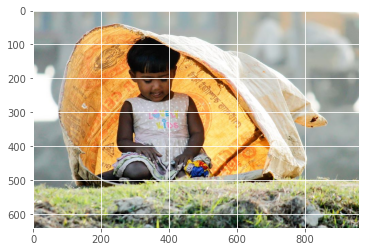

Referance Captions: 
শিশু বসে
ভিতরে ঘর বানিয়ে বসে আছে একজন বাচ্চা
Predicted Caption for Greedy Search : 
['বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে বেডে']
Scores for Greedy Search : 
{'Bleu_1': 2.5641025640368184e-17, 'Bleu_2': 2.597621667263174e-17, 'Bleu_3': 2.632186702273938e-17, 'Bleu_4': 2.6678529803596046e-17, 'METEOR': 0.06092634510715021, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=3: 
['বেডে বেডে চরে লিখছে। সেতুসহ মুস্তাফিজের ডেস্কের জ্বালিয়েছে। খাচ্ছে।']
Scores for Beam Search, k=3: 
{'Bleu_1': 1.1111111109876545e-16, 'Bleu_2': 1.1785113018384495e-16, 'Bleu_3': 1.2565790683898578e-16, 'Bleu_4': 1.34851118576642e-16, 'METEOR': 0.3083798438308514, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=5: 
['বেডে বেডে চরে লিখছে। সেতুসহ মুস্তাফিজের ডেস্কের জ্বালিয়েছে। খাচ

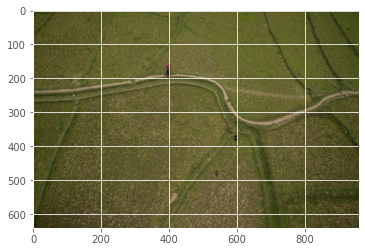

Referance Captions: 
মানুষ
উপরে আঁকাবাঁকা রাস্তা যার উপর দিয়ে ১ জন হেটে
Predicted Caption for Greedy Search : 
['বেডে করা লিখছে। সন্ধ্যারবেলা প্রবাহিত জ্বালিয়েছে। কাহচে সোসাইটির মাছ মরে কারণে খাচ্ছে।']
Scores for Greedy Search : 
{'Bleu_1': 8.33333333263889e-17, 'Bleu_2': 8.7038827970266e-17, 'Bleu_3': 9.11609179238116e-17, 'Bleu_4': 9.578464407697051e-17, 'METEOR': 0.29757829437450267, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=3: 
['ব্রিক্রি মাছ ব্রিক্রি কারণে খাচ্ছে।']
Scores for Beam Search, k=3: 
{'Bleu_1': 1.9999999996000001e-16, 'Bleu_2': 2.2360679769966743e-16, 'Bleu_3': 2.5543647739782093e-16, 'Bleu_4': 3.02137539638741e-16, 'METEOR': 0.1623711568852003, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=5: 
['মাছ ব্রিক্রি জেলা আশেপাশে চিৎকার']
Scores for Beam Search, k=5: 
{'Bleu_1': 1.9999999996000001e-16, 'Bleu_2': 2.2360679769966743e-16, 'Bleu_3': 2.5543647739782093e-16, 'Bleu_4': 3.02137539638741e-16, 'ME

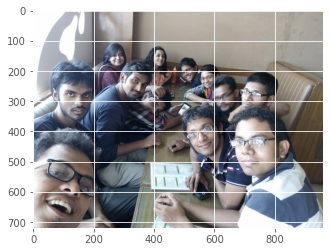

Referance Captions: 
নারী ও পুরুষ বসে
কয়েকজন ছেলেমেয়ে বসে তাকিয়ে
Predicted Caption for Greedy Search : 
['করা মাছ চরে জ্বালিয়েছে। কাহচে ঝাঁপ উড়িয়ে মাছ মরে জ্বালিয়েছে। খাচ্ছে।']
Scores for Greedy Search : 
{'Bleu_1': 9.090909090082646e-17, 'Bleu_2': 9.534625891545801e-17, 'Bleu_3': 1.0033557297469767e-16, 'Bleu_4': 1.0600313378380957e-16, 'METEOR': 0.2929357063001447, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=3: 
['মাছ গেঙ্গি টুকরা মাছ গেঙ্গি খাচ্ছে।']
Scores for Beam Search, k=3: 
{'Bleu_1': 1.666666666388889e-16, 'Bleu_2': 1.8257418580158344e-16, 'Bleu_3': 2.027400664774394e-16, 'Bleu_4': 2.295748846116193e-16, 'METEOR': 0.1383157394198417, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=5: 
['মাছ গেঙ্গি টুকরা মাছ গেঙ্গি খাচ্ছে।']
Scores for Beam Search, k=5: 
{'Bleu_1': 1.666666666388889e-16, 'Bleu_2': 1.8257418580158344e-16, 'Bleu_3': 2.027400664774394e-16, 'Bleu_4': 2.295748846116193e-16, 'METEOR': 0.1383157394

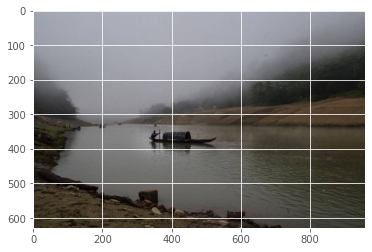

Referance Captions: 
নৌকায় একজন মানুষ বসে
খালে একটি নৌকায় ১ জন লোক বসে
Predicted Caption for Greedy Search : 
['জন্মদিনের বাবা। লিখছে। জন্মদিনের শ্মাশান সম্মেলন মাছ ব্রিক্রি সিমেন্ত']
Scores for Greedy Search : 
{'Bleu_1': 1.1111111109876545e-16, 'Bleu_2': 1.1785113018384495e-16, 'Bleu_3': 1.2565790683898578e-16, 'Bleu_4': 1.34851118576642e-16, 'METEOR': 0.2102341746785327, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=3: 
['লিখছে। চমমা মাছ জেলা জ্বালিয়েছে। খাচ্ছে।']
Scores for Beam Search, k=3: 
{'Bleu_1': 1.4108028743474226e-16, 'Bleu_2': 1.5454571169206621e-16, 'Bleu_3': 1.7161576114765806e-16, 'Bleu_4': 1.943309442852187e-16, 'METEOR': 0.1889193289439105, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=5: 
['লিখছে। চমমা মাছ জেলা জ্বালিয়েছে। খাচ্ছে।']
Scores for Beam Search, k=5: 
{'Bleu_1': 1.4108028743474226e-16, 'Bleu_2': 1.5454571169206621e-16, 'Bleu_3': 1.7161576114765806e-16, 'Bleu_4': 1.943309442852187e-16, '

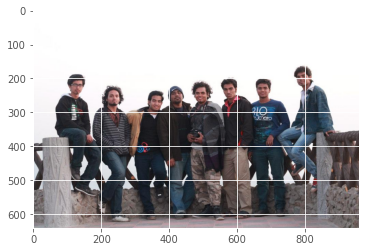

Referance Captions: 
কয়েকজন পুরুষ দাড়িয়ে
জন ছেলে একসাথে একটি দেয়ালে ধাক্কা দিয়ে দাড়িয়ে তাকিয়ে আছে
Predicted Caption for Greedy Search : 
['করা মিলে কারণে কাহচে ঝাঁপ উড়িয়ে হারমোনিয়াম জেলা কারণে খাচ্ছে।']
Scores for Greedy Search : 
{'Bleu_1': 9.999999998000002e-17, 'Bleu_2': 1.0540925531727854e-16, 'Bleu_3': 1.115721583233711e-16, 'Bleu_4': 1.1868405216912992e-16, 'METEOR': 0.2594399272564426, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=3: 
['করা প্রকৃতির জেলা খাচ্ছে।']
Scores for Beam Search, k=3: 
{'Bleu_1': 2.499999999375e-16, 'Bleu_2': 2.8867513451061596e-16, 'Bleu_3': 3.4668063705012784e-16, 'Bleu_4': 4.518010015696094e-16, 'METEOR': 0.2028169014084507, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SPICE': 0.0}
Predicted Caption for Beam Search, k=5: 
['করা প্রকৃতির জেলা খাচ্ছে।']
Scores for Beam Search, k=5: 
{'Bleu_1': 2.499999999375e-16, 'Bleu_2': 2.8867513451061596e-16, 'Bleu_3': 3.4668063705012784e-16, 'Bleu_4': 4.518010015696094e-16, 'METEOR': 0.20281690

In [62]:
i=0
for img_id in test_features:
  img=cv2.imread(img_dir+ "/" + img_id)                   
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) #displaying the image
  photo=test_features[img_id]
  plt.show()
 
  print("Referance Captions: ")
  print(References['pycoco'][img_id][0])
  print(References['pycoco'][img_id][1])
  print("Predicted Caption for Greedy Search : ")                                         
  print(Hypotheses['pycoco']['greedy'][img_id])
  print("Scores for Greedy Search : ")
  print(individual_scores[img_id]['greedy'])
  print("Predicted Caption for Beam Search, k=3: ")
  print(Hypotheses['pycoco']['beam_3'][img_id])
  print("Scores for Beam Search, k=3: ")
  print(individual_scores[img_id]['beam_3'])
  print("Predicted Caption for Beam Search, k=5: ")
  print(Hypotheses['pycoco']['beam_5'][img_id])
  print("Scores for Beam Search, k=5: ")
  print(individual_scores[img_id]['beam_5'])
  print("Predicted Caption for Beam Search, k=7: ")
  print(Hypotheses['pycoco']['beam_7'][img_id])
  print("Scores for Beam Search, k=7: ")
  print(individual_scores[img_id]['beam_7'])
  i += 1
  if(i==5):
    break

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [100]:
data = {}
for search_type in scores['pycoco']:
    data[search_type] = []
    for metric in scores['pycoco'][search_type]:
        data[search_type].append(round(scores['pycoco'][search_type][metric],4))

print(data)

{'greedy': [0.0033, 0.0, 0.0, 0.0, 0.2142, 0.0033, 0.0024, 0.0], 'beam_3': [0.0046, 0.0, 0.0, 0.0, 0.1884, 0.0032, 0.0023, 0.0001], 'beam_5': [0.005, 0.0, 0.0, 0.0, 0.1841, 0.0033, 0.0027, 0.0], 'beam_7': [0.0056, 0.0, 0.0, 0.0, 0.1836, 0.0038, 0.0033, 0.0]}


In [0]:
metrics = ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4 ', '  METEOR  ', ' ROUGE', 'CIDEr', 'SPICE']

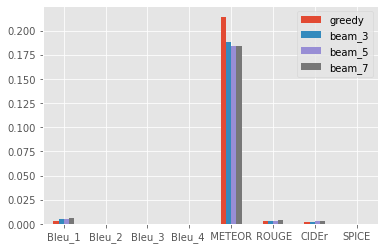

In [102]:
df = pd.DataFrame(data, index=metrics)
ax = df.plot.bar(rot=0)

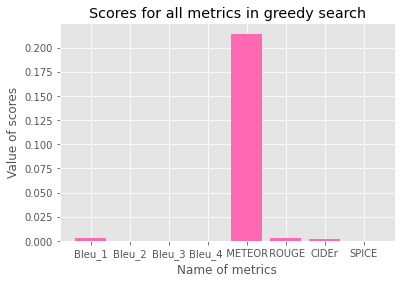

In [109]:
data1 = data['greedy']

x_pos = [i for i, _ in enumerate(metrics)]

plt.bar(x_pos, data1, color='hotpink')
plt.xlabel("Name of metrics")
plt.ylabel("Value of scores")
plt.title("Scores for all metrics in greedy search")

plt.xticks(x_pos, metrics)

plt.show()

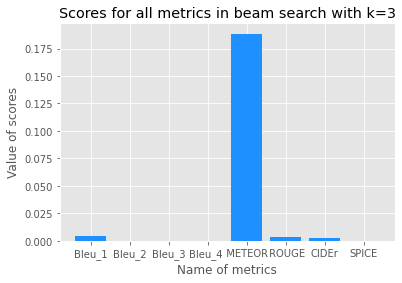

In [108]:
data2 = data['beam_3']

x_pos = [i for i, _ in enumerate(metrics)]

plt.bar(x_pos, data2, color='dodgerblue')
plt.xlabel("Name of metrics")
plt.ylabel("Value of scores")
plt.title("Scores for all metrics in beam search with k=3")

plt.xticks(x_pos, metrics)

plt.show()

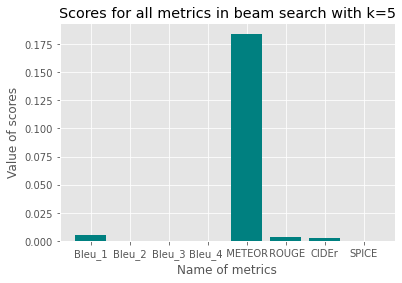

In [110]:
data3 = data['beam_5']

x_pos = [i for i, _ in enumerate(metrics)]

plt.bar(x_pos, data3, color='teal')
plt.xlabel("Name of metrics")
plt.ylabel("Value of scores")
plt.title("Scores for all metrics in beam search with k=5")

plt.xticks(x_pos, metrics)

plt.show()

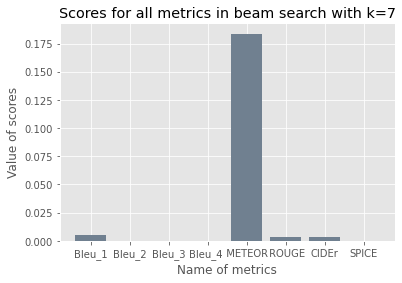

In [111]:
data4 = data['beam_7']

x_pos = [i for i, _ in enumerate(metrics)]

plt.bar(x_pos, data4, color='slategrey')
plt.xlabel("Name of metrics")
plt.ylabel("Value of scores")
plt.title("Scores for all metrics in beam search with k=7")

plt.xticks(x_pos, metrics)

plt.show()

# **THE END**
other visualization will be added soon :)